Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges

       * Comptage du nombre de fois ou une commune est dans un path
       * Comptabilisation en fonction de la longueur totale du trajet (cuts)

        .....

In [1]:
class CFG:
    data_path = './osm_datas/'
    data_path_mappers = './datas'
    path_paths = './tourism_paths'
    score_path = './tourism_scores'
    area_name = 'france'

    cuts = 10

    

import os
os.environ['USE_PYGEOS'] = '0'

import joblib
joblib.dump(
    CFG, 
    os.path.join(
        CFG.score_path,
        'CFG_for_tourism_score_cuts.pkl'
    ) 
)   


# %load_ext autoreload
# %autoreload


# %aimport OSM_helper_functions
# %aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
# from OSM_helper_functions import *
# from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 



C:\Users\demo\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


' To retrieve http data from OSMnx and cache them locally\n    before building graph. Raise and exception if requests\n    are all done. intercept then set to False and retry.'

In [2]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))

In [3]:
for _, _, files in os.walk(CFG.path_paths):
    dfs = [ joblib.load(
        os.path.join(CFG.path_paths, file)
    ) for file in files if file.startswith('f')]


In [4]:
paths_df = pd.concat(dfs, axis=0, ignore_index=True)   
paths_df 

,start,goal,path,distance,duration
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9
1,70279,2194867,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",497284.011,26570.0
2,70279,906453,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",1080369.844,57932.3
3,70279,960185,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",472196.949,26191.8
4,70279,130427,"[70227, 70333, 70330, 70295, 422156, 73911, 39...",565091.085,30295.4
...,...,...,...,...,...
955535,76306,1268202,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",212753.687,11592.7
955536,76306,125102,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",573113.996,31114.1
955537,76306,112497,"[76308, 76310, 76312, 76314, 721854, 1621669, ...",222969.196,10957.1
955538,76306,388818,"[77321, 77530, 368243, 77763, 80299, 80129, 16...",168658.752,8991.4


In [5]:
# Remove paths not found until fix on graph

error_idx = paths_df.path == ['error']
number_of_errors = np.unique(error_idx, return_counts=True)[1][1]
print(f'Number of paths with error: {number_of_errors}')
paths_df = paths_df[~error_idx.values].reset_index(drop=True)
paths_df

Number of paths with error: 1515


,start,goal,path,distance,duration
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9
1,70279,2194867,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",497284.011,26570.0
2,70279,906453,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",1080369.844,57932.3
3,70279,960185,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",472196.949,26191.8
4,70279,130427,"[70227, 70333, 70330, 70295, 422156, 73911, 39...",565091.085,30295.4
...,...,...,...,...,...
954020,76306,1268202,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",212753.687,11592.7
954021,76306,125102,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",573113.996,31114.1
954022,76306,112497,"[76308, 76310, 76312, 76314, 721854, 1621669, ...",222969.196,10957.1
954023,76306,388818,"[77321, 77530, 368243, 77763, 80299, 80129, 16...",168658.752,8991.4


In [6]:
paths_df['labels'] = pd.cut(
    paths_df['distance'].values.flatten() / 1e3, 
    CFG.cuts, 
    precision=0, 
    ) 
paths_df['intervals'] = paths_df['labels']  
paths_df = paths_df.set_index('labels', drop=True).sort_index().reset_index(drop=True)
paths_df

,start,goal,path,distance,duration,intervals
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9,"(2.0, 164.0]"
1,103599,2307315,"[111607, 111775, 121688, 535640, 453031]",36524.816,1889.9,"(2.0, 164.0]"
2,103599,571502,"[122704, 137910, 1028002, 1022810, 556769, 556...",31876.220,1819.6,"(2.0, 164.0]"
3,103599,1172518,"[106941, 122801, 142074, 129418, 126439, 12645...",127013.647,7047.3,"(2.0, 164.0]"
4,80348,366236,"[102786, 104978, 105086, 226968, 107024, 10740...",142810.669,8007.7,"(2.0, 164.0]"
...,...,...,...,...,...,...
954020,170100,296071,"[149032, 78617, 73746, 74773, 156356, 156344, ...",1464380.728,75403.8,"(1443.0, 1603.0]"
954021,170100,337903,"[149032, 78617, 73746, 74773, 156356, 156344, ...",1451804.464,74545.2,"(1443.0, 1603.0]"
954022,170100,1300609,"[149032, 78617, 73746, 74773, 156356, 156344, ...",1471295.913,75657.8,"(1443.0, 1603.0]"
954023,170100,417924,"[149032, 78617, 73746, 74773, 156356, 156344, ...",1446472.185,74530.9,"(1443.0, 1603.0]"


In [7]:
bins = pd.unique(paths_df['intervals'].values.flatten())
bins

array([Interval(2.0, 164.0, closed='right'),
       Interval(164.0, 323.0, closed='right'),
       Interval(323.0, 483.0, closed='right'),
       Interval(483.0, 643.0, closed='right'),
       Interval(643.0, 803.0, closed='right'),
       Interval(803.0, 963.0, closed='right'),
       Interval(963.0, 1123.0, closed='right'),
       Interval(1123.0, 1283.0, closed='right'),
       Interval(1283.0, 1443.0, closed='right'),
       Interval(1443.0, 1603.0, closed='right')], dtype=object)

In [8]:
scores_df = pd.DataFrame(index= Nodes.index)
scores_df[bins] = [0] * CFG.cuts
scores_df

,"(2.0, 164.0]","(164.0, 323.0]","(323.0, 483.0]","(483.0, 643.0]","(643.0, 803.0]","(803.0, 963.0]","(963.0, 1123.0]","(1123.0, 1283.0]","(1283.0, 1443.0]","(1443.0, 1603.0]"
osmid,,,,,,,,,,
2531584,0,0,0,0,0,0,0,0,0,0
279376,0,0,0,0,0,0,0,0,0,0
1022241,0,0,0,0,0,0,0,0,0,0
153920,0,0,0,0,0,0,0,0,0,0
111919,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
71694,0,0,0,0,0,0,0,0,0,0
5827802,0,0,0,0,0,0,0,0,0,0
2573037,0,0,0,0,0,0,0,0,0,0


  0%|          | 0/10 [00:00<?, ?it/s]

(2.0, 164.0]km, counts:59632
(164.0, 323.0]km, counts:137726
(323.0, 483.0]km, counts:179097
(483.0, 643.0]km, counts:204119
(643.0, 803.0]km, counts:167787
(803.0, 963.0]km, counts:116985
(963.0, 1123.0]km, counts:65426
(1123.0, 1283.0]km, counts:20782
(1283.0, 1443.0]km, counts:2165
(1443.0, 1603.0]km, counts:306
Scored paths total: 954025


,"(2.0, 164.0]","(164.0, 323.0]","(323.0, 483.0]","(483.0, 643.0]","(643.0, 803.0]","(803.0, 963.0]","(963.0, 1123.0]","(1123.0, 1283.0]","(1283.0, 1443.0]","(1443.0, 1603.0]",total_count
osmid,,,,,,,,,,,
2531584,0,0,0,0,0,0,0,0,0,0,0
279376,1,1,0,1,0,0,0,0,0,0,3
1022241,0,0,0,0,0,0,0,0,0,0,0
153920,6,122,138,48,26,32,9,1,0,0,382
111919,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
71694,0,0,0,8,31,6,5,0,0,0,50
5827802,14,4,6,36,30,25,13,10,0,0,138
2573037,0,0,0,0,0,0,0,0,0,0,0


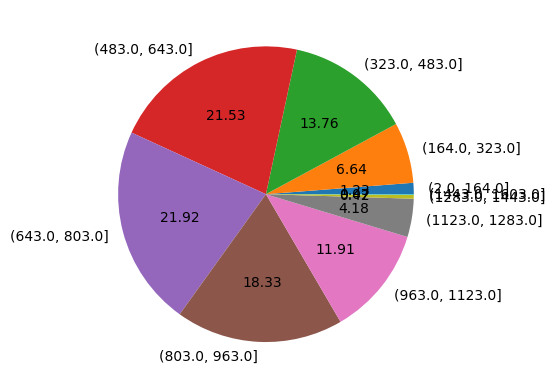

In [9]:
total = 0
for bin in tqdm(bins):
    print(bin, end='km, counts:')
    df = paths_df[paths_df['intervals'].values ==  bin]
    total += df.shape[0]
    print(df.shape[0])
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        scores_df.loc[row.path, bin] += 1

    # break
print(f'Scored paths total: {total}')


scores_df.sum().plot(kind='pie',autopct='%.2f')  

scores_df['total_count'] = scores_df.sum(axis=1)  

scores_df

In [11]:
scores_df.replace(0,np.nan).dropna(how='all').replace(np.nan,0)

,"(2.0, 164.0]","(164.0, 323.0]","(323.0, 483.0]","(483.0, 643.0]","(643.0, 803.0]","(803.0, 963.0]","(963.0, 1123.0]","(1123.0, 1283.0]","(1283.0, 1443.0]","(1443.0, 1603.0]",total_count
osmid,,,,,,,,,,,
279376,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
153920,6.0,122.0,138.0,48.0,26.0,32.0,9.0,1.0,0.0,0.0,382.0
414315,33.0,1448.0,1632.0,1923.0,1459.0,840.0,108.0,10.0,0.0,0.0,7453.0
164862,0.0,49.0,31.0,31.0,40.0,12.0,0.0,0.0,0.0,0.0,163.0
125040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
111397,79.0,207.0,281.0,171.0,342.0,171.0,82.0,0.0,0.0,0.0,1333.0
3287341,4.0,17.0,13.0,15.0,5.0,11.0,4.0,0.0,0.0,0.0,69.0
133323,6.0,1.0,74.0,29.0,1.0,1.0,0.0,0.0,0.0,0.0,112.0


In [12]:
joblib.dump(
    scores_df,
    os.path.join(
        CFG.score_path,
        'Scores_cuts.pkl'
    ))

['./tourism_scores\\Scores_cuts.pkl']

------------------------------